# Loading the Data

In [44]:
from pyspark.sql import SparkSession
from pyspark import Row
from pyspark.sql import SQLContext
import sys
import json
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import lit
from pyspark.ml.feature import MinMaxScaler
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import StandardScaler
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col

In [45]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()


In [46]:
df = spark.read.load('steam_dataset.csv', 
                      format='com.databricks.spark.csv', 
                      header='true', 
                      inferSchema='true')

In [47]:
df = df.withColumnRenamed("User ID", "userId").withColumnRenamed("_c0", "num").\
        withColumnRenamed("Game Title","gameTitle").withColumnRenamed("Hours Played","hoursPlayed").\
        withColumnRenamed("Game ID","gameId")

In [48]:
print((df.count(), len(df.columns)))

(70489, 5)


In [87]:
df.show()

+---+---------+--------------------+-----------+------+--------------------+
|num|   userId|           gameTitle|hoursPlayed|gameId|         normalizedH|
+---+---------+--------------------+-----------+------+--------------------+
|  0|151603712|The Elder Scrolls...|      273.0|  3067|  0.9772677791179138|
|  1|151603712|           Fallout 4|       87.0|  1162| 0.16622799627972654|
|  2|151603712|               Spore|       14.9|  2813|-0.14815893029357077|
|  3|151603712|   Fallout New Vegas|       12.1|  1163|-0.16036813132554348|
|  4|151603712|       Left 4 Dead 2|        8.9|  1733|-0.17432150393351228|
|  5|151603712|            HuniePop|        8.5|  1535|-0.17606567550950838|
|  6|151603712|       Path of Exile|        8.1|  2197|-0.17780984708550449|
|  7|151603712|         Poly Bridge|        7.5|  2251|-0.18042610444949864|
|  8|151603712|         Left 4 Dead|        3.3|  1732|-0.19873990599745772|
|  9|151603712|     Team Fortress 2|        2.8|  2994|-0.20092012046745283|

In [49]:
from pyspark.sql.functions import isnan, when, count, col
# df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).count()
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+------+---------+-----------+------+
|num|userId|gameTitle|hoursPlayed|gameId|
+---+------+---------+-----------+------+
|  0|     0|        0|          0|     0|
+---+------+---------+-----------+------+



In [50]:
df.groupby().max('hoursPlayed').collect()[0].asDict()['max(hoursPlayed)']

11754.0

In [51]:
df.groupby().min('hoursPlayed').collect()[0].asDict()['min(hoursPlayed)']

0.1

In [52]:
df.groupby().count().show()

+-----+
|count|
+-----+
|70489|
+-----+



# Filtering DF to hoursPlayed < 5000

In [53]:
df_filtered = df.filter(df.hoursPlayed < 5000)

In [54]:
df_filtered.count()

70472

In [55]:
df_filtered.groupby().max('hoursPlayed').collect()[0].asDict()['max(hoursPlayed)']

4845.0

In [56]:
df_filtered.groupby().min('hoursPlayed').collect()[0].asDict()['min(hoursPlayed)']

0.1

In [130]:
# df_filtered.show()

# Filtering DF to hoursPlayed >5


In [141]:
df_filtered_new = df.filter(df.hoursPlayed > 5)

In [142]:
df_filtered_new.count()

33721

In [143]:
df_filtered_new.groupby().max('hoursPlayed').collect()[0].asDict()['max(hoursPlayed)']

11754.0

In [144]:
df_filtered_new.groupby().min('hoursPlayed').collect()[0].asDict()['min(hoursPlayed)']

5.1

# Normalization

In [57]:
df_norm = df.select(
    _mean(col('hoursPlayed')).alias('mean'),
    _stddev(col('hoursPlayed')).alias('std')
).collect()

mean = df_norm[0]['mean']
std = df_norm[0]['std']

print(mean)
print(std)

48.8780632439
229.335235997


In [58]:
df = df.withColumn("normalizedH", (((df['hoursPlayed']-mean)/std)))

In [107]:
# df.show()

In [59]:
from pyspark.sql.functions import isnan, when, count, col
# df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).count()
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+------+---------+-----------+------+-----------+
|num|userId|gameTitle|hoursPlayed|gameId|normalizedH|
+---+------+---------+-----------+------+-----------+
|  0|     0|        0|          0|     0|          0|
+---+------+---------+-----------+------+-----------+



In [60]:
df.groupby().max('normalizedH').collect()[0].asDict()['max(normalizedH)']

51.039352439146015

In [61]:
df.groupby().min('normalizedH').collect()[0].asDict()['min(normalizedH)']

-0.2126932786054265

# Normalizing df_filtered 

In [62]:
df_norm_filtered = df_filtered.select(
    _mean(col('hoursPlayed')).alias('mean'),
    _stddev(col('hoursPlayed')).alias('std')
).collect()

mean = df_norm_filtered[0]['mean']
std = df_norm_filtered[0]['std']

print(mean)
print(std)

47.2530622091
201.898808172


In [63]:
df_filtered = df_filtered.withColumn("normalizedH", (((df_filtered['hoursPlayed']-mean)/std)))

In [64]:
df_filtered.groupby().max('normalizedH').collect()[0].asDict()['max(normalizedH)']

23.763126594138065

In [65]:
df_filtered.groupby().min('normalizedH').collect()[0].asDict()['min(normalizedH)']

-0.233547996821227

# Normalizing df_filtered > 5 

In [145]:
df_norm_filtered_new = df_filtered_new.select(
    _mean(col('hoursPlayed')).alias('mean'),
    _stddev(col('hoursPlayed')).alias('std')
).collect()

mean = df_norm_filtered_new[0]['mean']
std = df_norm_filtered_new[0]['std']

print(mean)
print(std)

100.467492067
323.788343543


In [146]:
df_filtered_new = df_filtered_new.withColumn("normalizedH", (((df_filtered_new['hoursPlayed']-mean)/std)))

In [147]:
df_filtered_new.groupby().max('normalizedH').collect()[0].asDict()['max(normalizedH)']

35.99120456414786

In [148]:
df_filtered_new.groupby().min('normalizedH').collect()[0].asDict()['min(normalizedH)']

-0.2945365204435602

# Data Visualization buy Plotly

In [66]:
# Standard plotly imports
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
import matplotlib
import numpy as np  
import matplotlib.pyplot as plt  
import pandas as pd  

In [67]:
sum_hours = df.groupBy('gameId').sum('hoursPlayed').withColumnRenamed("sum(hoursPlayed)","sum_hours")
# .orderBy('count(hoursPlayed)', ascending=False)

In [68]:
h = sum_hours.toPandas() 

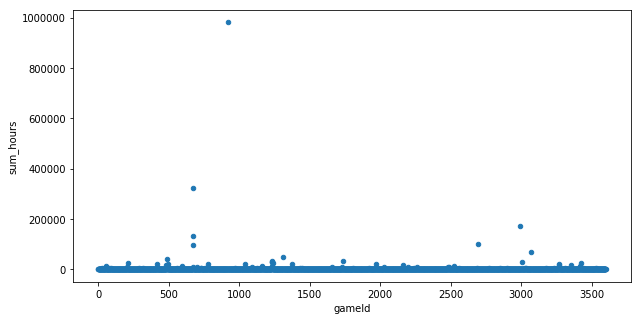

In [69]:
h.plot.scatter(y='sum_hours', x='gameId', figsize=(10,5))

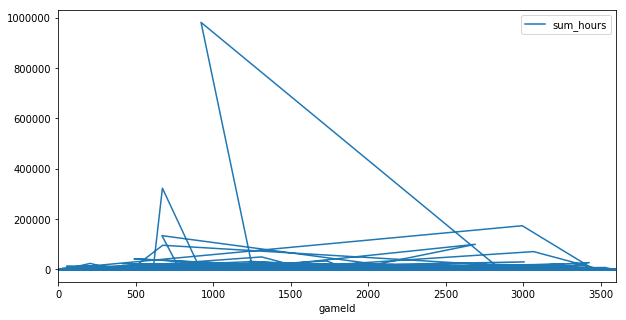

In [72]:
h.plot.line(y='sum_hours', x='gameId', figsize=(10,5)) 

In [73]:
visualize = df.toPandas()

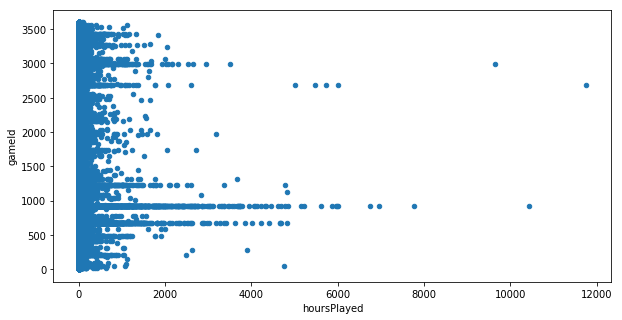

In [74]:
visualize.plot.scatter(x='hoursPlayed', y='gameId', figsize=(10,5))

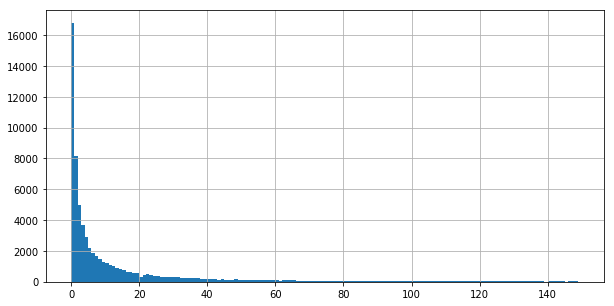

In [75]:
visualize['hoursPlayed'].hist( bins = range(0,150,1) , figsize=(10,5))

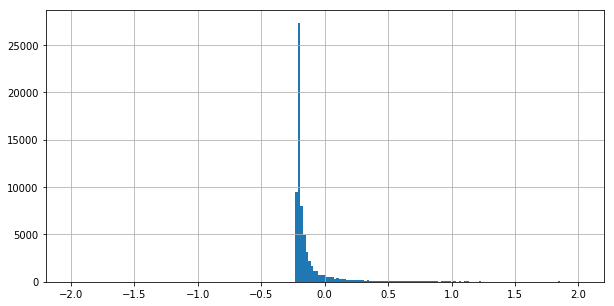

In [76]:
visualize['normalizedH'].hist( bins = np.linspace(-2,2,200) , figsize=(10,5))

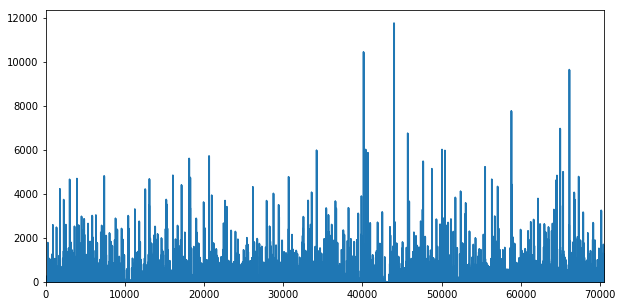

In [77]:
visualize['hoursPlayed'].plot.area(figsize=(10,5))

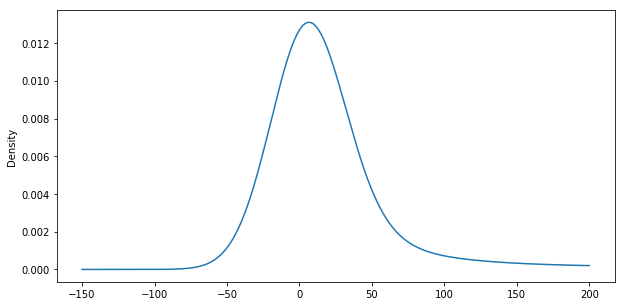

In [80]:
visualize['hoursPlayed'].plot.kde(ind = np.linspace(-150,200,500),figsize=(10,5))

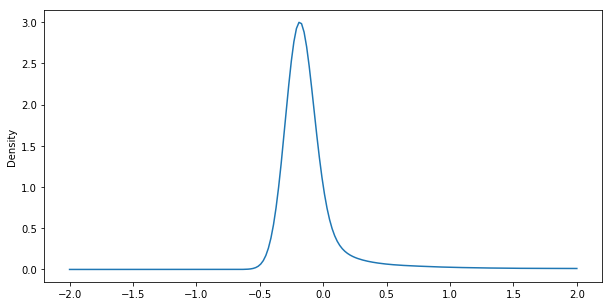

In [81]:
visualize['normalizedH'].plot.kde(ind = np.linspace(-2,2,200),figsize=(10,5))

In [82]:
visualize_filtered = df_filtered.toPandas()

In [83]:
import numpy as np

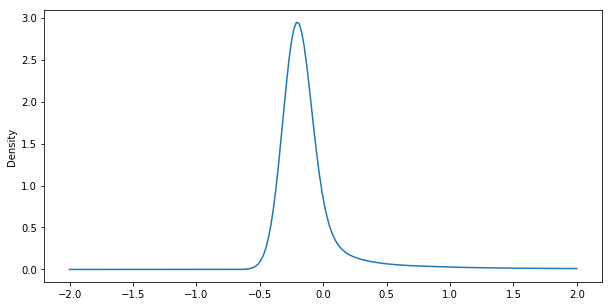

In [84]:
visualize_filtered['normalizedH'].plot.kde(ind = np.linspace(-2,2,200),figsize=(10,5))

# Baseline - Basic ALS

# Main DF

In [25]:
# df = spark.read.load('steam_data_w_game_id.csv', 
#                       format='com.databricks.spark.csv', 
#                       header='true', 
#                       inferSchema='true')
# df = df.withColumnRenamed("User ID", "userId").withColumnRenamed("_c0", "num").\
#         withColumnRenamed("Game Title","gameTitle").withColumnRenamed("Hours Played","hoursPlayed").\
#         withColumnRenamed("Game ID","gameId")
# df_norm = df.select(
#     _mean(col('hoursPlayed')).alias('mean'),
#     _stddev(col('hoursPlayed')).alias('std')
# ).collect()

# mean = df_norm[0]['mean']
# std = df_norm[0]['std']
# df = df.withColumn("normalizedH", (df['hoursPlayed']-mean)/std)
# (training, test) = df.randomSplit([0.8, 0.2], 123)

In [85]:
(training, test) = df.randomSplit([0.8, 0.2], 123)
als = ALS(rank = 10, maxIter=10, regParam=0.01, alpha= 13, implicitPrefs = True, userCol="userId", itemCol="gameId", ratingCol="normalizedH",
          coldStartStrategy="drop").setSeed(123)

model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="normalizedH",predictionCol="prediction")

rmse = evaluator.evaluate(predictions)

#Result
rmse

0.8551382600447174

In [16]:
# df.show()

# Filtered DF < 5000

In [86]:
(training, test) = df_filtered.randomSplit([0.8, 0.2], 123)
als = ALS(rank = 10, maxIter=10, regParam=0.01, alpha= 13, implicitPrefs = True, userCol="userId", itemCol="gameId", ratingCol="normalizedH",
          coldStartStrategy="drop").setSeed(123)

model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="normalizedH",predictionCol="prediction")

rmse = evaluator.evaluate(predictions)

#Result
rmse

0.8955676469489794

# Filtered DF > 5

In [149]:
(training, test) = df_filtered_new.randomSplit([0.8, 0.2], 123)
als = ALS(rank = 10, maxIter=10, regParam=0.01, alpha= 13, implicitPrefs = True, userCol="userId", itemCol="gameId", ratingCol="normalizedH",
          coldStartStrategy="drop").setSeed(123)

model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="normalizedH",predictionCol="prediction")

rmse = evaluator.evaluate(predictions)

#Result
rmse

0.7298222915157959

# Filtered DF >2

In [114]:
(training, test) = df_filtered_new.randomSplit([0.8, 0.2], 123)
als = ALS(rank = 10, maxIter=10, regParam=0.01, alpha= 13, implicitPrefs = True, userCol="userId", itemCol="gameId", ratingCol="normalizedH",
          coldStartStrategy="drop").setSeed(123)

model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="normalizedH",predictionCol="prediction")

rmse = evaluator.evaluate(predictions)

#Result
rmse

0.9219532392459633

# Filtered DF>3

In [123]:
(training, test) = df_filtered_new.randomSplit([0.8, 0.2], 123)
als = ALS(rank = 10, maxIter=10, regParam=0.01, alpha= 13, implicitPrefs = True, userCol="userId", itemCol="gameId", ratingCol="normalizedH",
          coldStartStrategy="drop").setSeed(123)

model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="normalizedH",predictionCol="prediction")

rmse = evaluator.evaluate(predictions)

#Result
rmse

0.857043885881333

# Filtered DF>4

In [140]:
(training, test) = df_filtered_new.randomSplit([0.8, 0.2], 123)
als = ALS(rank = 10, maxIter=10, regParam=0.01, alpha= 13, implicitPrefs = True, userCol="userId", itemCol="gameId", ratingCol="normalizedH",
          coldStartStrategy="drop").setSeed(123)

model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="normalizedH",predictionCol="prediction")

rmse = evaluator.evaluate(predictions)

#Result
rmse

0.9497821616527128

# ALS Global Average

In [12]:
# df = spark.read.load('steam_data_w_game_id.csv', 
#                       format='com.databricks.spark.csv', 
#                       header='true', 
#                       inferSchema='true')
# df = df.withColumnRenamed("User ID", "userId").withColumnRenamed("_c0", "num").\
#         withColumnRenamed("Game Title","gameTitle").withColumnRenamed("Hours Played","hoursPlayed").\
#         withColumnRenamed("Game ID","gameId")
# df_norm = df.select(
#     _mean(col('hoursPlayed')).alias('mean'),
#     _stddev(col('hoursPlayed')).alias('std')
# ).collect()

# mean = df_norm[0]['mean']
# std = df_norm[0]['std']
# df = df.withColumn("normalizedH", (df['hoursPlayed']-mean)/std)
# (training, test) = df.randomSplit([0.8, 0.2], 123)

In [18]:
test.show()

+---+---------+--------------------+-----------+------+--------------------+
|num|   userId|           gameTitle|hoursPlayed|gameId|         normalizedH|
+---+---------+--------------------+-----------+------+--------------------+
|  1|151603712|           Fallout 4|       87.0|  1162| 0.16622799627972654|
|  2|151603712|               Spore|       14.9|  2813|-0.14815893029357077|
|  3|151603712|   Fallout New Vegas|       12.1|  1163|-0.16036813132554348|
|  8|151603712|         Left 4 Dead|        3.3|  1732|-0.19873990599745772|
| 10|151603712|         Tomb Raider|        2.5|  3247| -0.2022282491494499|
| 16|151603712|SEGA Genesis & Me...|        0.8|  2535|-0.20964097834743337|
| 24|151603712|         Garry's Mod|        0.1|  1313| -0.2126932786054265|
| 27| 59945701|Ultra Street Figh...|      238.0|  3327|  0.8246527662182549|
| 29| 59945701|The Elder Scrolls...|       58.0|  3067|0.039775557020009185|
| 32| 59945701|Company of Heroes...|       10.2|   641|-0.16865294631152494|

In [20]:
training.show()

+---+---------+--------------------+-----------+------+--------------------+--------------------+
|num|   userId|           gameTitle|hoursPlayed|gameId|         normalizedH|      normalizedHAVG|
+---+---------+--------------------+-----------+------+--------------------+--------------------+
|  0|151603712|The Elder Scrolls...|      273.0|  3067|  0.9772677791179138|0.001253190493281...|
|  4|151603712|       Left 4 Dead 2|        8.9|  1733|-0.17432150393351228|0.001253190493281...|
|  5|151603712|            HuniePop|        8.5|  1535|-0.17606567550950838|0.001253190493281...|
|  6|151603712|       Path of Exile|        8.1|  2197|-0.17780984708550449|0.001253190493281...|
|  7|151603712|         Poly Bridge|        7.5|  2251|-0.18042610444949864|0.001253190493281...|
|  9|151603712|     Team Fortress 2|        2.8|  2994|-0.20092012046745283|0.001253190493281...|
| 11|151603712|     The Banner Saga|        2.0|  3024|-0.20440846361944504|0.001253190493281...|
| 12|151603712|Dead 

In [294]:
global_mean = training.groupBy().avg("normalizedH").collect()[0]['avg(normalizedH)']
training = training.withColumn('normalizedHAVG',lit(global_mean))
print(global_mean)

0.0012531904932816308


In [295]:
als = ALS(rank = 10, maxIter=10, regParam=0.01, alpha= 13, implicitPrefs = True,userCol="userId", itemCol="gameId", ratingCol="normalizedHAVG",
          coldStartStrategy="drop").setSeed(123)

model = als.fit(training)

# Evaluate the model by computing the RMSE on the test dataI
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="normalizedH",
                                predictionCol="prediction")

rmse = evaluator.evaluate(predictions)

#Result
rmse

0.8803801031927555

# ALS with Bias

In [28]:
# df = spark.read.load('steam_dataset.csv', 
#                       format='com.databricks.spark.csv', 
#                       header='true', 
#                       inferSchema='true')
# df = df.withColumnRenamed("User ID", "userId").withColumnRenamed("_c0", "num").\
#         withColumnRenamed("Game Title","gameTitle").withColumnRenamed("Hours Played","hoursPlayed").\
#         withColumnRenamed("Game ID","gameId")
# df_norm = df.select(
#     _mean(col('hoursPlayed')).alias('mean'),
#     _stddev(col('hoursPlayed')).alias('std')
# ).collect()

# mean = df_norm[0]['mean']
# std = df_norm[0]['std']
# df = df.withColumn("normalizedH", (df['hoursPlayed']-mean)/std)
# (training, test) = df.randomSplit([0.8, 0.2], 123)

In [296]:
#################

#global average 
# global_mean = training.groupBy().avg("normalizedH").collect()[0]['avg(normalizedH)']

#User_mean
user_mean = training.groupBy("userId").agg({"normalizedH": "avg"})
user_mean = user_mean.withColumnRenamed('avg(normalizedH)', 'user_mean')

#item_mean
item_mean = training.groupBy('gameId').agg({"normalizedH": "avg"})
item_mean = item_mean.withColumnRenamed('avg(normalizedH)', 'item_mean')

#joining DFs
# mainDF = training.alias('mainDF')
userDF = user_mean.alias('userDF')
itemDF = item_mean.alias('itemDF')

training = training.join(userDF, training.userId == userDF.userId, 'outer')\
    .select(training.userId, training.gameId, training.normalizedH , userDF.user_mean)

training = training.join(itemDF, training.gameId == itemDF.gameId, 'outer')\
    .select(training.userId, training.gameId, training.normalizedH ,training.user_mean, itemDF.item_mean)

#user_item_interaction  
training = training.withColumn('user_item_interaction',training.normalizedH\
                               - (training.user_mean + training.item_mean - global_mean))


#################
#####test#######

test_user_mean = user_mean.alias('test_user_mean')
test = test.join(test_user_mean, test.userId == test_user_mean.userId, 'inner') \
    .select(test.userId, test.gameId, test.normalizedH, test_user_mean.user_mean)

test_item_mean = item_mean.alias('test_item_mean')
test = test.join(test_item_mean, test.gameId == test_item_mean.gameId, 'inner') \
    .select(test.userId, test.gameId, test.normalizedH, test.user_mean, test_item_mean.item_mean)

als = ALS( rank = 10, maxIter=10, regParam=0.01, alpha= 13, implicitPrefs = True,userCol="userId", itemCol="gameId", ratingCol="user_item_interaction",
          coldStartStrategy="drop").setSeed(123)


model = als.fit(training)
predictions = model.transform(test)

predictions = predictions.withColumn('prediction_calculated',
                                     predictions.prediction + predictions.user_mean + predictions.item_mean - global_mean)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="normalizedH", predictionCol="prediction_calculated")
rmse = evaluator.evaluate(predictions)

rmse


0.9299355411105491

# Normalization based on Game ID - Version 1.1

In [164]:
df = spark.read.load('steam_dataset.csv', 
                      format='com.databricks.spark.csv', 
                      header='true', 
                      inferSchema='true')
df = df.withColumnRenamed("User ID", "userId").withColumnRenamed("_c0", "num").\
        withColumnRenamed("Game Title","gameTitle").withColumnRenamed("Hours Played","hoursPlayed").\
        withColumnRenamed("Game ID","gameId")


In [165]:
from pyspark.sql.functions import *
#item_mean
item_mean = df.groupBy('gameId').agg({"hoursPlayed": "avg"})
item_mean = item_mean.withColumnRenamed('avg(hoursPlayed)', 'item_mean')

#item_std
item_stddev = df.groupBy('gameId').agg(stddev_pop("hoursPlayed"))
item_stddev = item_stddev.withColumnRenamed('stddev_pop(hoursPlayed)', 'item_stddev')

#joining DFs
itemDF = item_mean.alias('itemDF')
itemsdDF = item_stddev.alias('itemsdDF')

from pyspark.sql.functions import * #for decs or asc

df = df.join(itemDF, df.gameId == itemDF.gameId, 'inner')\
    .select( df.num, df.userId, df.gameTitle, df.hoursPlayed ,df.gameId, itemDF.item_mean)#.orderBy(asc("num"))

df = df.join(itemsdDF, df.gameId == itemsdDF.gameId, 'inner')\
    .select( df.num, df.userId, df.gameTitle, df.hoursPlayed ,df.gameId, df.item_mean , itemsdDF.item_stddev)


In [167]:
df = df.withColumn("item_normalizedH", (((df['hoursPlayed']-df['item_mean'])/df['item_stddev'])))

In [ ]:
# + (2.022429040605209)

In [169]:
df = df.na.fill(0)

In [145]:
# df.show()

In [48]:
print((df.count(), len(df.columns)))

(70489, 8)


In [170]:
from pyspark.sql.functions import isnan, when, count, col

# df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).count()
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+------+---------+-----------+------+---------+-----------+----------------+
|num|userId|gameTitle|hoursPlayed|gameId|item_mean|item_stddev|item_normalizedH|
+---+------+---------+-----------+------+---------+-----------+----------------+
|  0|     0|        0|          0|     0|        0|          0|               0|
+---+------+---------+-----------+------+---------+-----------+----------------+



In [160]:
df.groupby().max('item_normalizedH').collect()[0].asDict()['max(item_normalizedH)']

30.855317831282797

In [161]:
df.groupby().min('item_normalizedH').collect()[0].asDict()['min(item_normalizedH)']

-2.022429040605209

# Basic ALS with normalization 1.1

In [171]:
(training, test) = df.randomSplit([0.8, 0.2], 123)

In [172]:
als = ALS(maxIter=5, regParam=0.01, implicitPrefs = True, userCol="userId", itemCol="gameId", ratingCol="item_normalizedH",
          coldStartStrategy="drop").setSeed(123)

model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="item_normalizedH",predictionCol="prediction")

rmse = evaluator.evaluate(predictions)

#Result
rmse

0.9907262282078395

# Global average ALS with normalization 1.1

In [186]:
global_item_mean = training.groupBy().avg("item_normalizedH").collect()[0]['avg(item_normalizedH)']
training = training.withColumn('item_normalizedHAVG',abs(lit(global_item_mean)))
print(global_item_mean)

-7.66530948607956e-05


In [ ]:
# Note: I should have used absolute value for global average to be able to use 

In [119]:
# training.show()

In [187]:
als = ALS(maxIter=5, regParam=0.01,implicitPrefs = True,userCol="userId", itemCol="gameId", ratingCol="item_normalizedHAVG",
          coldStartStrategy="drop").setSeed(123)

model = als.fit(training)

# Evaluate the model by computing the RMSE on the test dataI
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="item_normalizedH",
                                predictionCol="prediction")

rmse = evaluator.evaluate(predictions)

#Result
rmse

1.003689438381288

In [181]:
# training.show()

In [182]:
# test.show()

# Bias ALS with normalization 1.1

In [188]:
#################

# #global average 
# global_mean = training.groupBy().avg("normalizedH").collect()[0]['avg(normalizedH)']
global_item_mean = -1*(global_item_mean)

#User_mean
user_mean = training.groupBy("userId").agg({"item_normalizedH": "avg"})
user_mean = user_mean.withColumnRenamed('avg(item_normalizedH)', 'user_mean')

#item_mean
item_mean = training.groupBy('gameId').agg({"item_normalizedH": "avg"})
item_mean = item_mean.withColumnRenamed('avg(item_normalizedH)', 'item_mean')

#joining DFs
# mainDF = training.alias('mainDF')
userDF = user_mean.alias('userDF')
itemDF = item_mean.alias('itemDF')

training = training.join(userDF, training.userId == userDF.userId, 'inner')\
    .select(training.userId, training.gameId, training.item_normalizedH , userDF.user_mean)

training = training.join(itemDF, training.gameId == itemDF.gameId, 'inner')\
    .select(training.userId, training.gameId, training.item_normalizedH ,training.user_mean, itemDF.item_mean)

#user_item_interaction  
training = training.withColumn('user_item_interaction',(training.item_normalizedH \
                                                        - (training.user_mean + training.item_mean - global_item_mean)))


#################
# #####test#######

test_user_mean = user_mean.alias('test_user_mean')
test = test.join(test_user_mean, test.userId == test_user_mean.userId, 'inner') \
    .select(test.userId, test.gameId, test.item_normalizedH, test_user_mean.user_mean)

test_itemmean = item_mean.alias('test_itemmean')
test = test.join(test_itemmean, test.gameId == test_itemmean.gameId, 'inner') \
    .select(test.userId, test.gameId, test.item_normalizedH, test.user_mean, test_itemmean.item_mean)

als = ALS( maxIter=5, regParam=0.01,implicitPrefs = True,userCol="userId", itemCol="gameId", ratingCol="user_item_interaction",
          coldStartStrategy="drop").setSeed(123)


model = als.fit(training)
predictions = model.transform(test)

predictions = predictions.withColumn('prediction_calculated',
                                     predictions.prediction + predictions.user_mean + predictions.item_mean - global_mean)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="item_normalizedH", predictionCol="prediction_calculated")
rmse = evaluator.evaluate(predictions)

rmse

1.0653275824340078

# # Normalization based on user ID - Version 1.2

In [199]:
df = spark.read.load('steam_dataset.csv', 
                      format='com.databricks.spark.csv', 
                      header='true', 
                      inferSchema='true')
df = df.withColumnRenamed("User ID", "userId").withColumnRenamed("_c0", "num").\
        withColumnRenamed("Game Title","gameTitle").withColumnRenamed("Hours Played","hoursPlayed").\
        withColumnRenamed("Game ID","gameId")

In [200]:
from pyspark.sql.functions import *
#item_mean
user_mean = df.groupBy('userId').agg({"hoursPlayed": "avg"})
user_mean = user_mean.withColumnRenamed('avg(hoursPlayed)', 'user_mean')

#item_std
user_stddev = df.groupBy('userId').agg(stddev_pop("hoursPlayed"))
user_stddev = user_stddev.withColumnRenamed('stddev_pop(hoursPlayed)', 'user_stddev')

#joining DFs
userDF = user_mean.alias('userDF')
usersdDF = user_stddev.alias('usersdDF')

df = df.join(userDF, df.userId == userDF.userId, 'inner')\
    .select( df.num, df.userId, df.gameTitle, df.hoursPlayed ,df.gameId, userDF.user_mean)#.orderBy(asc("num"))

df = df.join(usersdDF, df.userId == usersdDF.userId, 'inner')\
    .select( df.num, df.userId, df.gameTitle, df.hoursPlayed ,df.gameId, df.user_mean , usersdDF.user_stddev)


In [201]:
df = df.withColumn("user_normalizedH", (((df['hoursPlayed']-df['user_mean'])/df['user_stddev'])))

In [203]:
df = df.na.fill(0)

In [204]:
from pyspark.sql.functions import isnan, when, count, col

# df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).count()
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+------+---------+-----------+------+---------+-----------+----------------+
|num|userId|gameTitle|hoursPlayed|gameId|user_mean|user_stddev|user_normalizedH|
+---+------+---------+-----------+------+---------+-----------+----------------+
|  0|     0|        0|          0|     0|        0|          0|               0|
+---+------+---------+-----------+------+---------+-----------+----------------+



In [205]:
df.groupby().max('user_normalizedH').collect()[0].asDict()['max(user_normalizedH)']

16.33704506121575

In [206]:
df.groupby().min('user_normalizedH').collect()[0].asDict()['min(user_normalizedH)']

-2.111522133893264

# Basic ALS with normalization 1.2

In [207]:
(training, test) = df.randomSplit([0.8, 0.2], 123)

In [208]:
als = ALS(maxIter=5, regParam=0.01, implicitPrefs = True, userCol="userId", itemCol="gameId", ratingCol="user_normalizedH",
          coldStartStrategy="drop").setSeed(123)

model = als.fit(training)

# Evaluate the model by computing the RMSE on the test data
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="user_normalizedH",predictionCol="prediction")

rmse = evaluator.evaluate(predictions)

#Result
rmse

1.0305204916681345

# Global average ALS with normalization 1.2

In [222]:
global_user_mean = training.groupBy().avg("user_normalizedH").collect()[0]['avg(user_normalizedH)']
training = training.withColumn('user_normalizedHAVG',abs(lit(global_user_mean)))
print(global_user_mean)

-0.00045410581322508954


In [218]:
als = ALS(maxIter=5, regParam=0.01,implicitPrefs = True,userCol="userId", itemCol="gameId", ratingCol="user_normalizedHAVG",
          coldStartStrategy="drop").setSeed(123)

model = als.fit(training)

# Evaluate the model by computing the RMSE on the test dataI
predictions = model.transform(test)
evaluator = RegressionEvaluator(metricName="rmse", labelCol="user_normalizedH",
                                predictionCol="prediction")

rmse = evaluator.evaluate(predictions)

#Result
rmse

1.0318710251120213

# Bias ALS with normalization 1.2

In [223]:
#################

# #global average 
# global_mean = training.groupBy().avg("normalizedH").collect()[0]['avg(normalizedH)']
global_item_mean = -1*(global_item_mean)

#User_mean
user_mean = training.groupBy("userId").agg({"user_normalizedH": "avg"})
user_mean = user_mean.withColumnRenamed('avg(user_normalizedH)', 'user_mean')

#item_mean
item_mean = training.groupBy('gameId').agg({"user_normalizedH": "avg"})
item_mean = item_mean.withColumnRenamed('avg(user_normalizedH)', 'item_mean')

#joining DFs
# mainDF = training.alias('mainDF')
userDF = user_mean.alias('userDF')
itemDF = item_mean.alias('itemDF')

training = training.join(userDF, training.userId == userDF.userId, 'inner')\
    .select(training.userId, training.gameId, training.user_normalizedH , userDF.user_mean)

training = training.join(itemDF, training.gameId == itemDF.gameId, 'inner')\
    .select(training.userId, training.gameId, training.user_normalizedH ,training.user_mean, itemDF.item_mean)

#user_item_interaction  
training = training.withColumn('user_item_interaction',(training.user_normalizedH \
                                                        - (training.user_mean + training.item_mean - global_item_mean)))


#################
# #####test#######

test_user_mean = user_mean.alias('test_user_mean')
test = test.join(test_user_mean, test.userId == test_user_mean.userId, 'inner') \
    .select(test.userId, test.gameId, test.user_normalizedH, test_user_mean.user_mean)

test_itemmean = item_mean.alias('test_itemmean')
test = test.join(test_itemmean, test.gameId == test_itemmean.gameId, 'inner') \
    .select(test.userId, test.gameId, test.user_normalizedH, test.user_mean, test_itemmean.item_mean)

als = ALS( maxIter=5, regParam=0.01,implicitPrefs = True,userCol="userId", itemCol="gameId", ratingCol="user_item_interaction",
          coldStartStrategy="drop").setSeed(123)


model = als.fit(training)
predictions = model.transform(test)

predictions = predictions.withColumn('prediction_calculated',
                                     predictions.prediction + predictions.user_mean + predictions.item_mean - global_mean)

evaluator = RegressionEvaluator(metricName="rmse", labelCol="user_normalizedH", predictionCol="prediction_calculated")
rmse = evaluator.evaluate(predictions)

rmse

1.091957162111561